# YOLOv5 Balloon Detection Model
In this notebook a YOLOv5 model was trained over 250 epochs on the V2 Balloon Detection Dataset (https://www.kaggle.com/datasets/vbookshelf/v2-balloon-detection-dataset).The new model performas as well on balloons as YOLOv5 performas on other classes, showing classification success with high confidence on real world balloon images

In [38]:
import pandas as pd
import numpy as np
import os

import ast
import cv2

from sklearn.model_selection import train_test_split
import shutil
from tqdm.notebook import tqdm
import tqdm.notebook as tq

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set up YOLOv5

In [39]:
import torch
from IPython.display import Image, clear_output

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.13.1+cu116 (NVIDIA GeForce RTX 3080 Ti)


# Load V2 Balloon Detection Dataset

In [46]:
base_path = 'Balloon_Dataset/'

file = 'balloon-data.csv'

df_data = pd.read_csv(base_path + file)

# Convert bbox column entries from strings to lists
# "[........]" to [......]
df_data['bbox'] = df_data['bbox'].apply(ast.literal_eval)

print(df_data.shape)

df_data.head()

(74, 5)


fname  height  width  \
0  34020010494_e5cb88e1c4_k.jpg    1536   2048   
1  25899693952_7c8b8b9edc_k.jpg    1365   2048   
2  24362039530_b151b41a52_k.jpg    2048   1536   
3  18849792632_aad23ad513_k.jpg    2048   1536   
4  17178818589_16e58fc1e5_k.jpg    1536   2048   

                                                bbox  num_balloons  
0  [{'xmin': 994, 'ymin': 619, 'xmax': 1445, 'yma...             1  
1  [{'xmin': 135, 'ymin': 115, 'xmax': 811, 'ymax...             1  
2  [{'xmin': 579, 'ymin': 487, 'xmax': 920, 'ymax...             1  
3  [{'xmin': 534, 'ymin': 365, 'xmax': 871, 'ymax...            10  
4  [{'xmin': 748, 'ymin': 195, 'xmax': 1425, 'yma...             7

# Split dataset into training and testing

In [53]:
df_train, df_val = train_test_split(df_data, test_size=0.2, random_state=101)

print(df_train.shape)
print(df_val.shape)

(59, 5)
(15, 5)


# Define the file structure below for YOLO

-> base_dir

    -> images
        -> train
        -> validation
        
    -> labels
        -> train
        -> validation

In [51]:
yolo_path = base_path + 'yolov5/'

# Create a new directory inside the yolov5 directory
base_dir = yolo_path + 'base_dir'
os.mkdir(base_dir)

# Create directories inside the directory defined above for labels and images
# images
images = os.path.join(base_dir, 'images')
os.mkdir(images)
# labels
labels = os.path.join(base_dir, 'labels')
os.mkdir(labels)

# Create training and validation directories inside the above folders
# create new folders inside images
train = os.path.join(images, 'train')
os.mkdir(train)
validation = os.path.join(images, 'validation')
os.mkdir(validation)
# create new folders inside labels
train = os.path.join(labels, 'train')
os.mkdir(train)
validation = os.path.join(labels, 'validation')
os.mkdir(validation)

# Preprocess data
A separate text file must be created for each image with its bounding boxes. This function accomplishes this as well as moving the data into the file structure defined above.

In [54]:
# Iterate through each row in the dataframe

# We run the function below separately for
# the train and val sets.
# Remember that each image gets it's own text file
# containing the info for all bboxes on that image.

# For each image:
# 1- get the info for each bounding box
# 2- write the bounding box info to a txt file
# 3- save the txt file in the correct folder
# 4- copy the image to the correct folder


def process_data_for_yolo(df, data_type='train'):

    for _, row in tq.tqdm(df.iterrows(), total=len(df)):
        
        image_name = row['fname']
        bbox_list = row['bbox']
        
        image_width = row['width']
        image_height = row['height']
 
        
        # Convert into the Yolo input format
        # ...................................
        

        yolo_data = []
        
        # row by row
        for coord_dict in bbox_list:

            xmin = int(coord_dict['xmin'])
            ymin = int(coord_dict['ymin'])
            xmax = int(coord_dict['xmax'])
            ymax = int(coord_dict['ymax'])
            
            # We only have one class i.e. balloon.
            # We will set the class_id to 0 for all images.
            # Class numbers must start from 0.
            class_id = 0
            
            bbox_h = int(ymax - ymin)
            bbox_w = int(xmax - xmin)

            x_center = xmin + (bbox_w/2)
            y_center = ymin + (bbox_h/2)
            

            # Normalize
            # Yolo expects the dimensions to be normalized i.e.
            # all values between 0 and 1.

            x_center = x_center/image_width
            y_center = y_center/image_height
            bbox_w = bbox_w/image_width
            bbox_h = bbox_h/image_height

            # [class_id, x-center, y-center, width, height]
            yolo_list = [class_id, x_center, y_center, bbox_w, bbox_h]

            yolo_data.append(yolo_list)

        # convert to nump array
        yolo_data = np.array(yolo_data)


        # save the text file
        image_id = image_name.split('.')[0]
        np.savetxt('Balloon_Dataset/yolov5/base_dir/' + f"labels/{data_type}/{image_id}.txt",
                    yolo_data, 
                    fmt=["%d", "%f", "%f", "%f", "%f"]
                    ) # fmt means format the columns

        # Copy the image to images
        shutil.copyfile(base_path + f"images/{image_name}",
            'Balloon_Dataset/yolov5/base_dir/' + f"images/{data_type}/{image_name}")
        
        

# Call the function    
process_data_for_yolo(df_train, data_type='train')
process_data_for_yolo(df_val, data_type='validation')

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

# Create yaml file

In [10]:
import yaml

yaml_dict = {'train': 'base_dir/images/train',   # path to the train folder
            'val': 'base_dir/images/validation', # path to the val folder
            'nc': 1,                             # number of classes
            'names': ['balloon']}                # list of label names

with open(r'Balloon_Dataset/yolov5/my_data.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

# Train the model
The YOLOv5 model will be retrained based on its existing weights

In [57]:
# Change the working directory to the yolov5 folder
os.chdir('Balloon_Dataset/yolov5')

In [20]:
# Use Wheat Model
! python train.py --img 1024 --batch 2 --epochs 250 --data my_data.yaml --cfg models/yolov5s.yaml --name wheatmodel

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=my_data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=250, batch_size=2, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=wheatmodel, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...


requirements: 1 package updated per G:\My Drive\RIT\Year 4\Spring 2023\Advanced Robotics\Project\Code\Balloon_Dataset\yolov5\requirements.txt
requirements:  Restart runtime or rerun command for updates to take effect

fatal: canno

# View Training Results

In [44]:
wheatmodel_df = pd.read_csv('runs/train/wheatmodel6/results.csv')

display(wheatmodel_df)

epoch        train/box_loss        train/obj_loss  \
0                       0              0.114610              0.093028   
1                       1              0.095779              0.076573   
2                       2              0.087809              0.069469   
3                       3              0.083697              0.072789   
4                       4              0.090397              0.053717   
..                    ...                   ...                   ...   
245                   245              0.013647              0.015200   
246                   246              0.014115              0.021455   
247                   247              0.014586              0.016473   
248                   248              0.014992              0.018612   
249                   249              0.015166              0.022869   

           train/cls_loss     metrics/precision        metrics/recall  \
0                       0              0.024515               0.29310   
1                       0              0.230590               0.32042   
2                       0              0.186860               0.20690   
3                       0              0.055541               0.32759   
4                       0              0.480210               0.22414   
..                    ...                   ...                   ...   
245                     0              0.869170               0.72414   
246                     0              0.912820               0.72212   
247                     0              0.912960               0.72340   
248                     0              0.912960               0.72340   
249                     0              0.885050               0.72414   

          metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
0                0.019224              0.004007              0.098090   
1                0.171130              0.052771              0.082506   
2                0.124250              0.030673              0.081240   
3                0.046081              0.011247              0.085154   
4                0.218800              0.051945              0.090087   
..                    ...                   ...                   ...   
245              0.767390              0.646650              0.024315   
246              0.768990              0.651650              0.024360   
247              0.768660              0.647720              0.024475   
248              0.768660              0.647720              0.024475   
249              0.769330              0.650730              0.024471   

             val/obj_loss          val/cls_loss                 x/lr0  \
0                0.059831                     0              0.073900   
1                0.052390                     0              0.046877   
2                0.044415                     0              0.019830   
3                0.054958                     0              0.009881   
4                0.050079                     0              0.009881   
..                    ...                   ...                   ...   
245              0.039046                     0              0.000338   
246              0.038757                     0              0.000298   
247              0.038425                     0              0.000258   
248              0.038425                     0              0.000219   
249              0.038865                     0              0.000179   

                    x/lr1                 x/lr2  
0                0.002900              0.002900  
1                0.005877              0.005877  
2                0.008830              0.008830  
3                0.009881              0.009881  
4                0.009881              0.009881  
..                    ...                   ...  
245              0.000338              0.000338  
246              0.000298              0.000298  
247              0.000258              0.000258  
248         

Next we will view trends within the above dataframe.

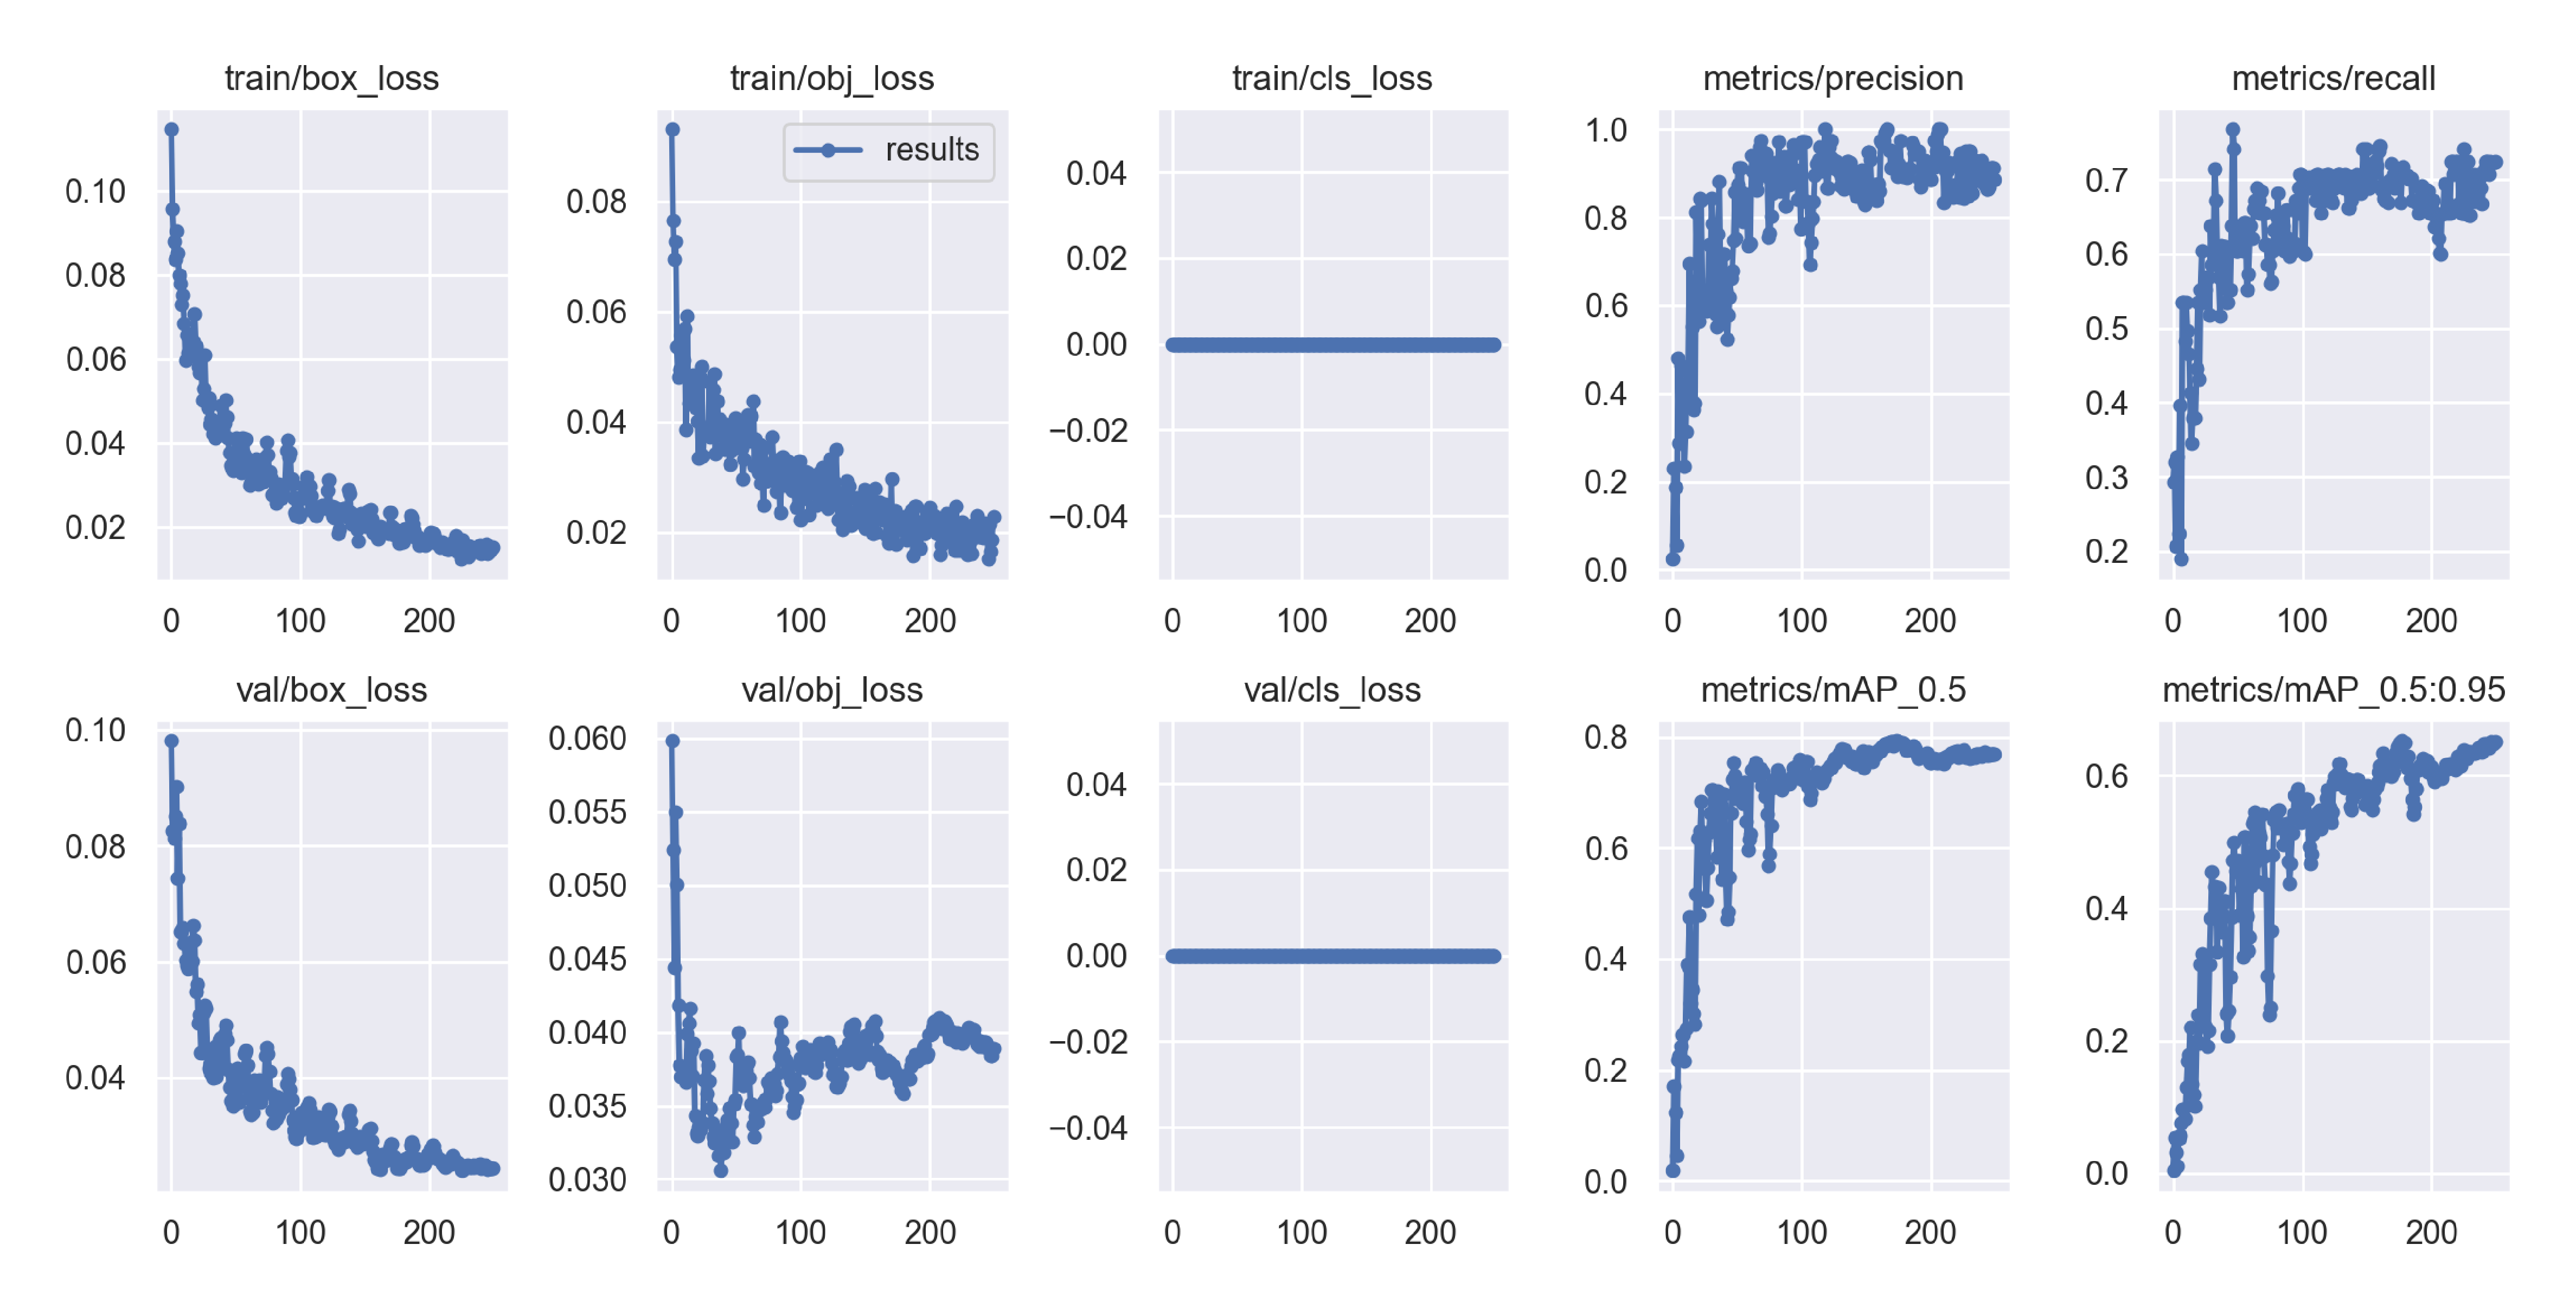

In [58]:
path2wm = 'runs/train/wheatmodel6/'

img = mpimg.imread(path2wm + 'results.png')

fig = plt.figure(figsize=(12,12), dpi=500)

plt.imshow(img, interpolation='none')
plt.axis('off')
plt.show()

# View P, R, PR, and F1 curves
As we can see, the new YOLO model is able to classify balloons as well as the other 80 classes

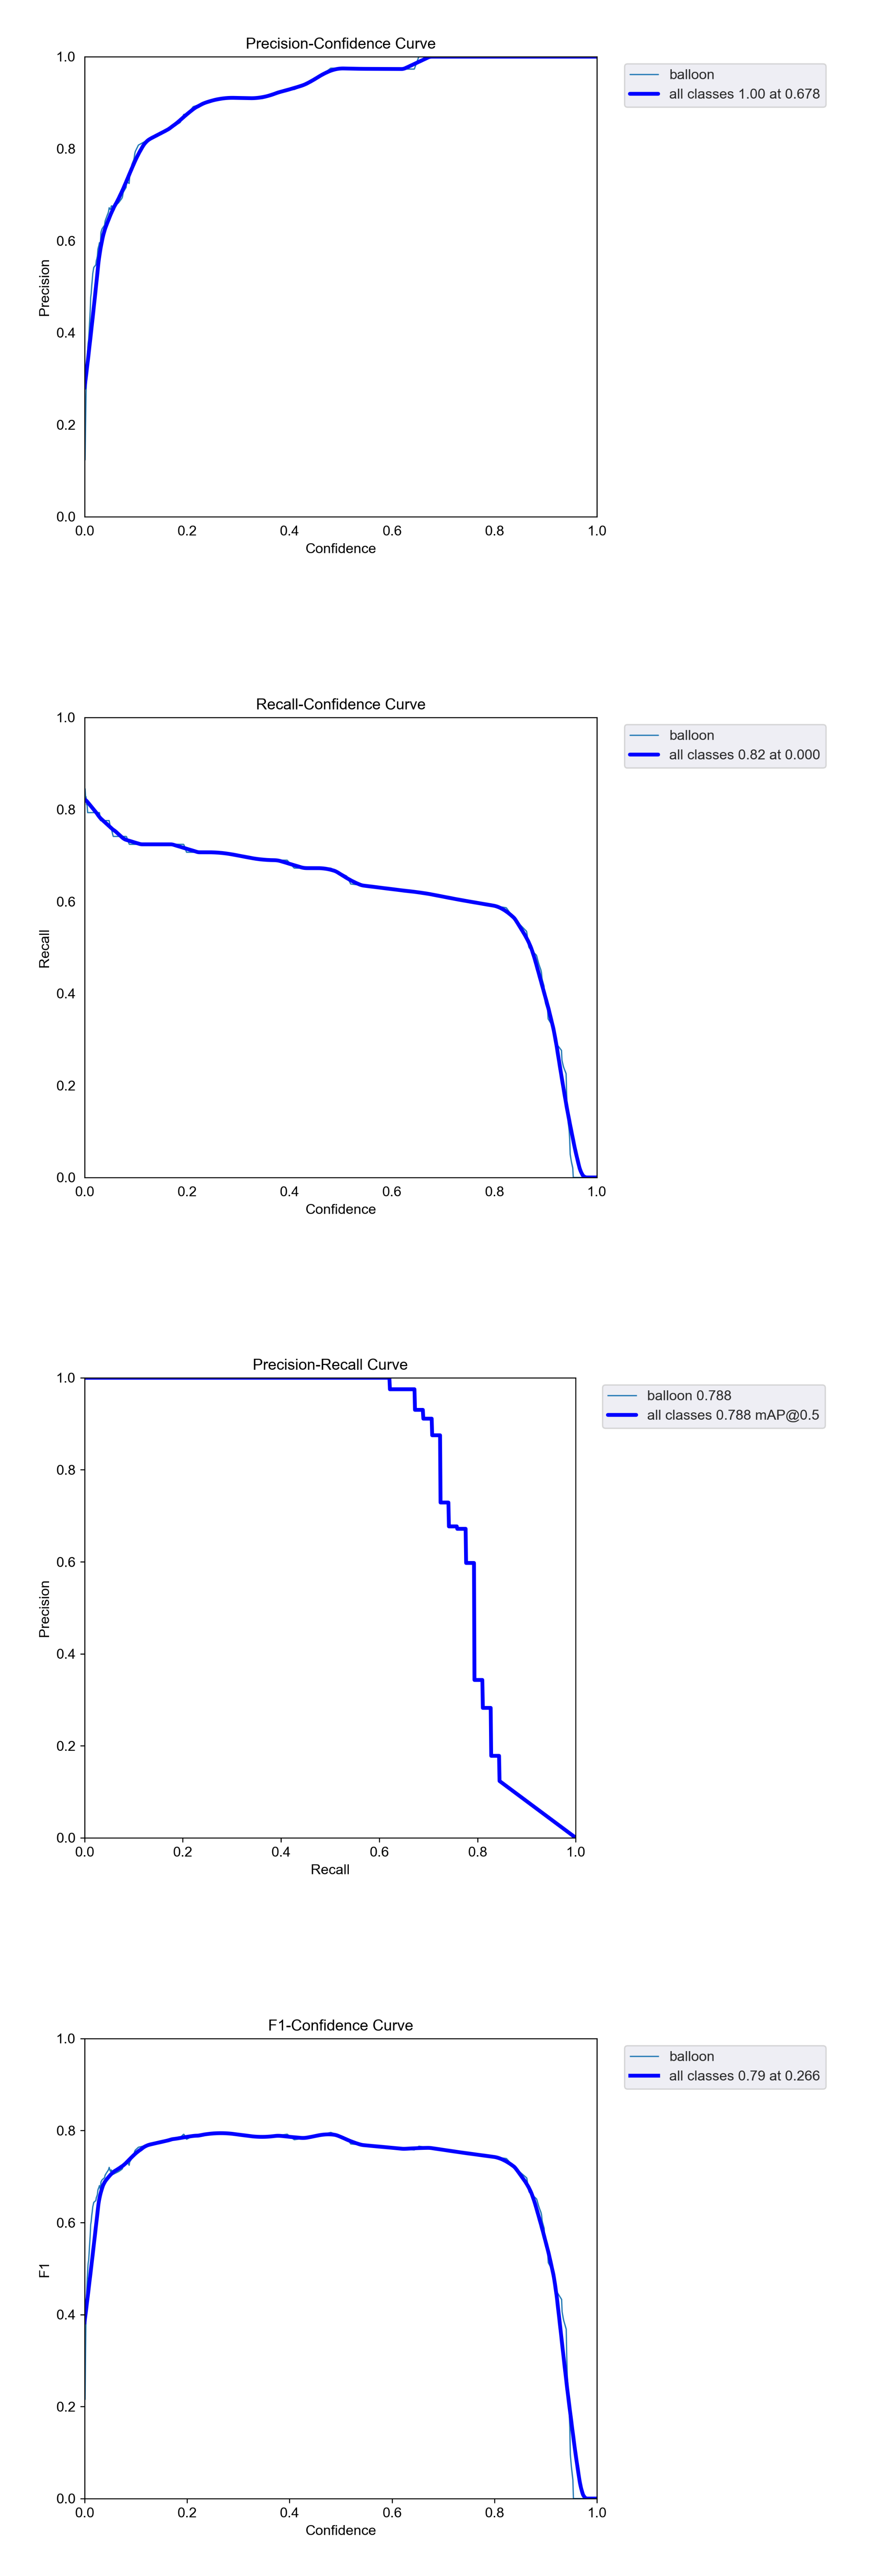

In [61]:
# Load the curve images
p_crv = mpimg.imread(path2wm + 'P_curve.png')
r_crv = mpimg.imread(path2wm + 'R_curve.png')
pr_crv = mpimg.imread(path2wm + 'PR_curve.png')
f1_crv = mpimg.imread(path2wm + 'F1_curve.png')

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(5, 15), dpi=500)

# Display the curves in the subplots
axs[0].imshow(p_crv)
axs[1].imshow(r_crv)
axs[2].imshow(pr_crv)
axs[3].imshow(f1_crv)

# Turn off the axis labels
for ax in axs.flatten():
    ax.axis('off')

# Show the plot
plt.show()

# View Confusion Matrix
We have a good model!

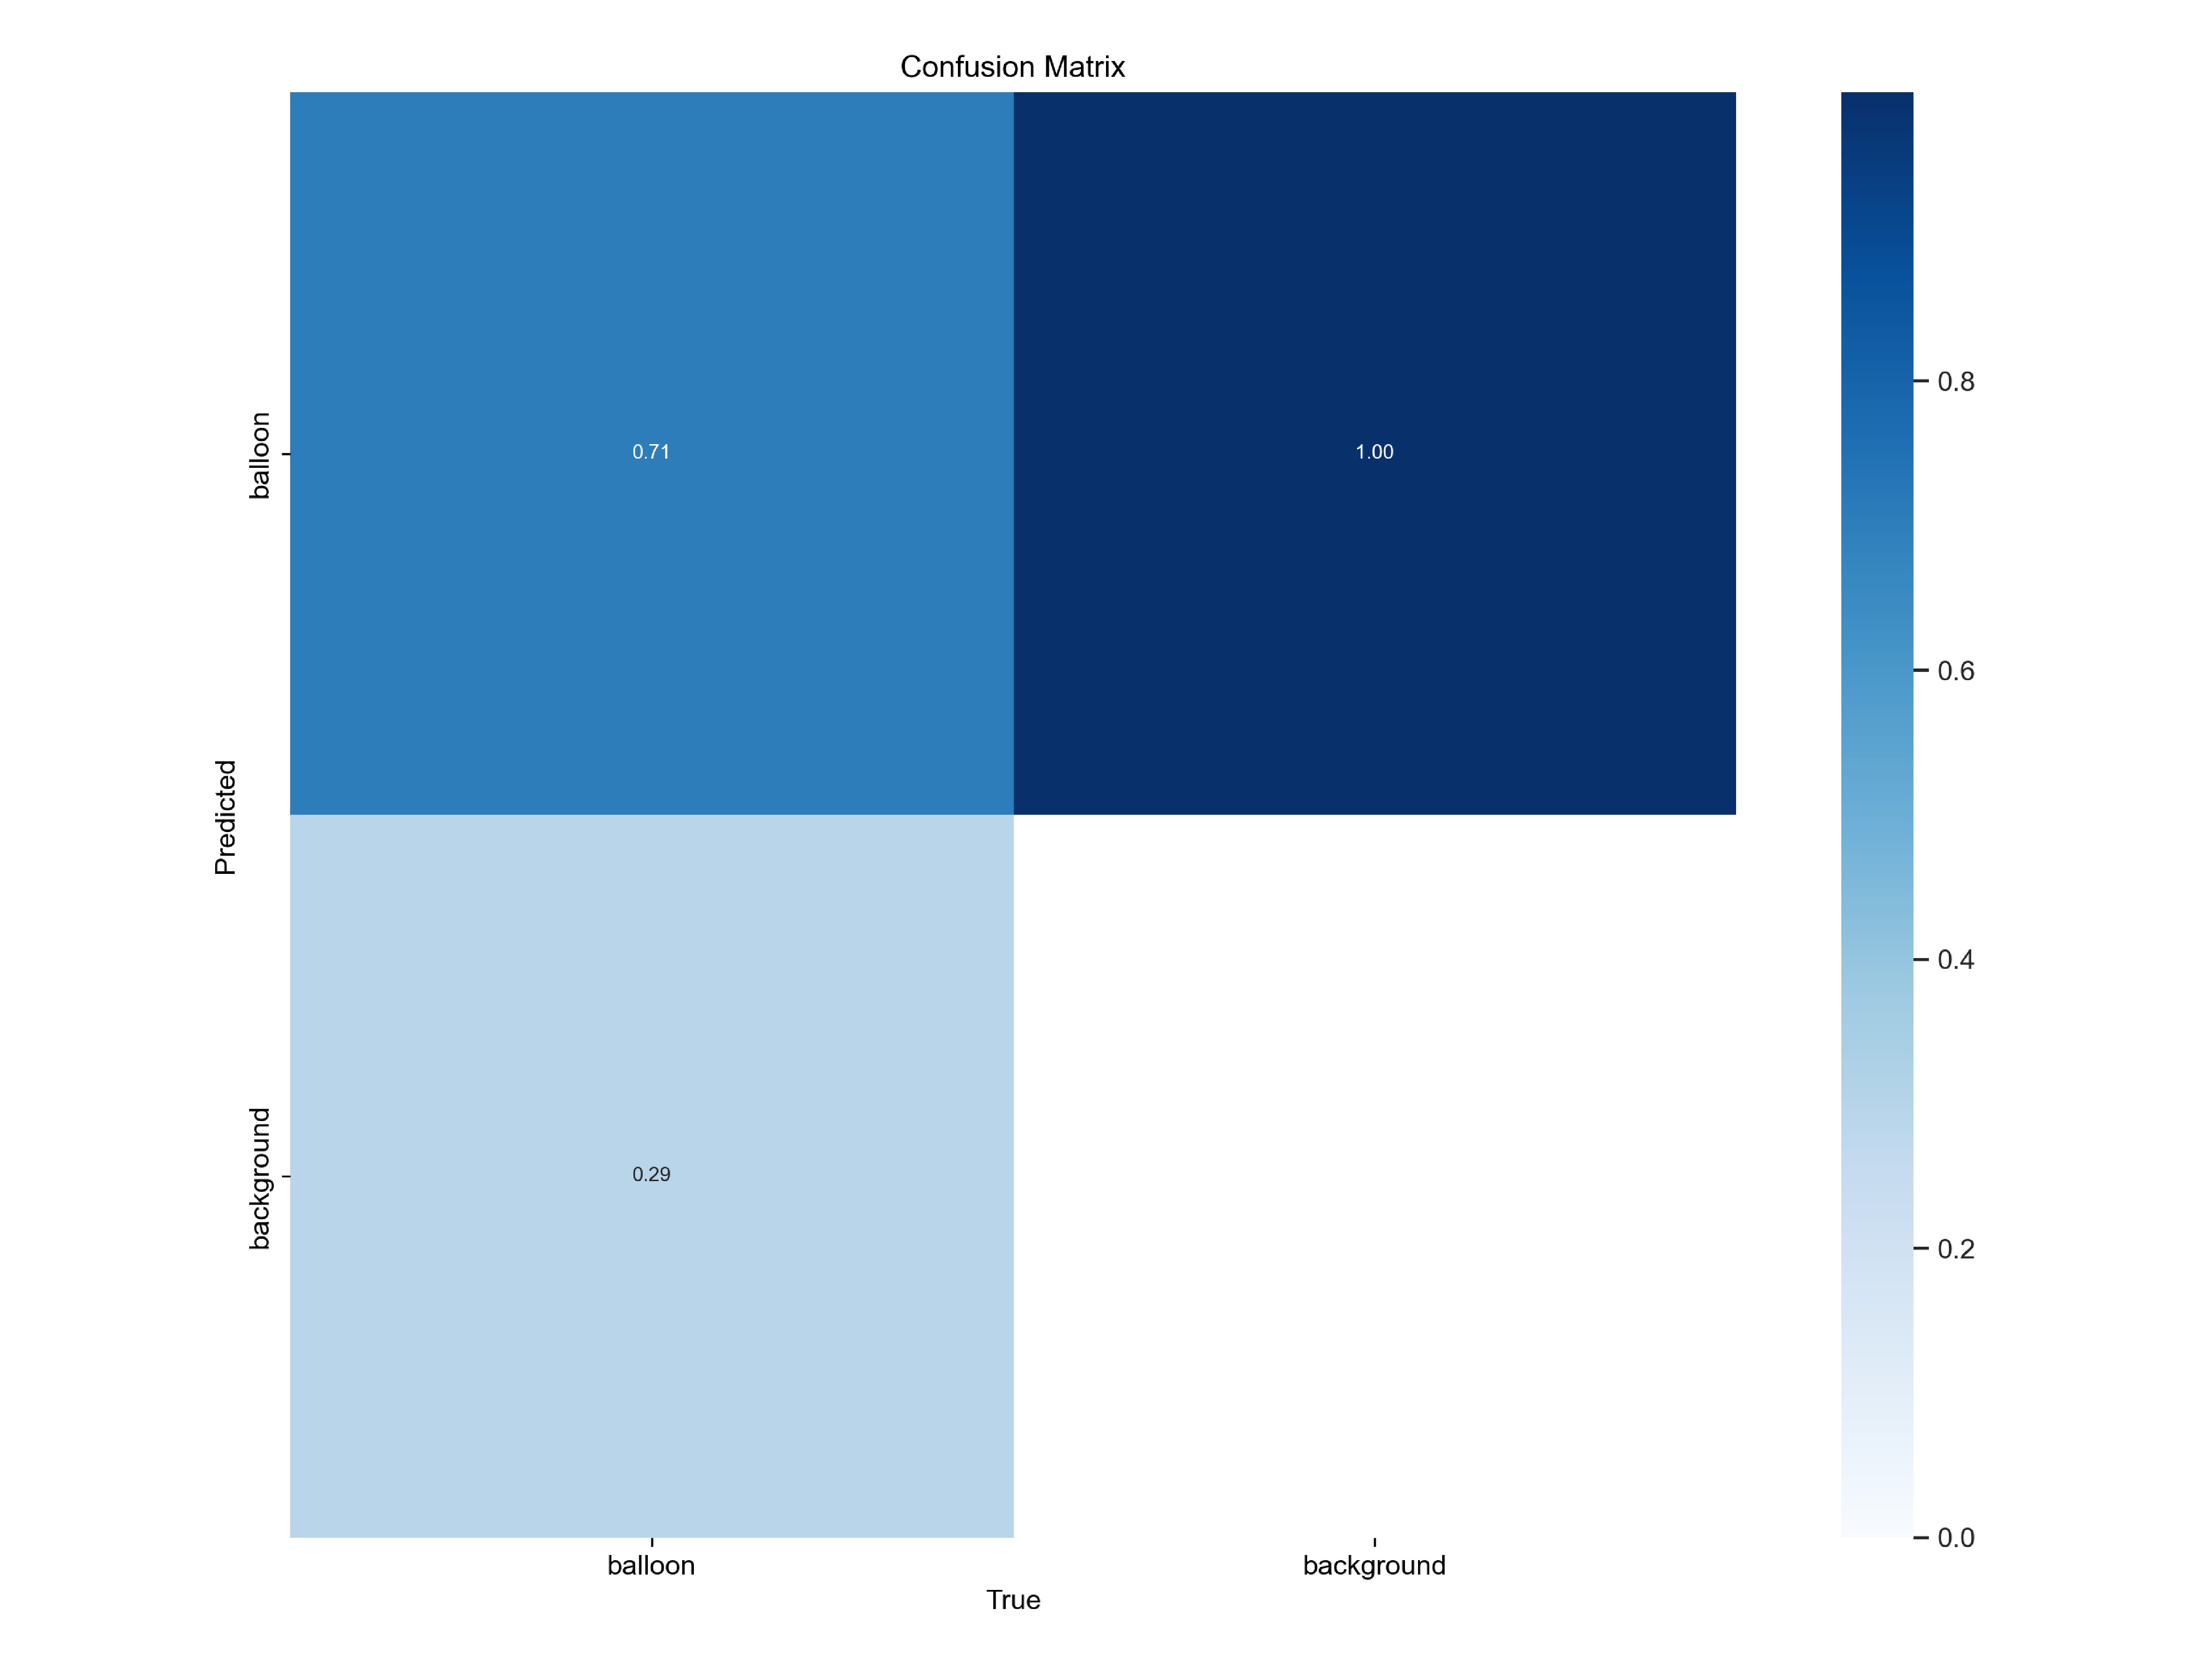

In [62]:
img = mpimg.imread(path2wm + 'confusion_matrix.png')

fig = plt.figure(figsize=(12,12), dpi=500)

plt.imshow(img, interpolation='none')
plt.axis('off')
plt.show()

# Display Validation Images
YOLO made predictions on three sets of validation images. They're shown below along with their labeled counterparts

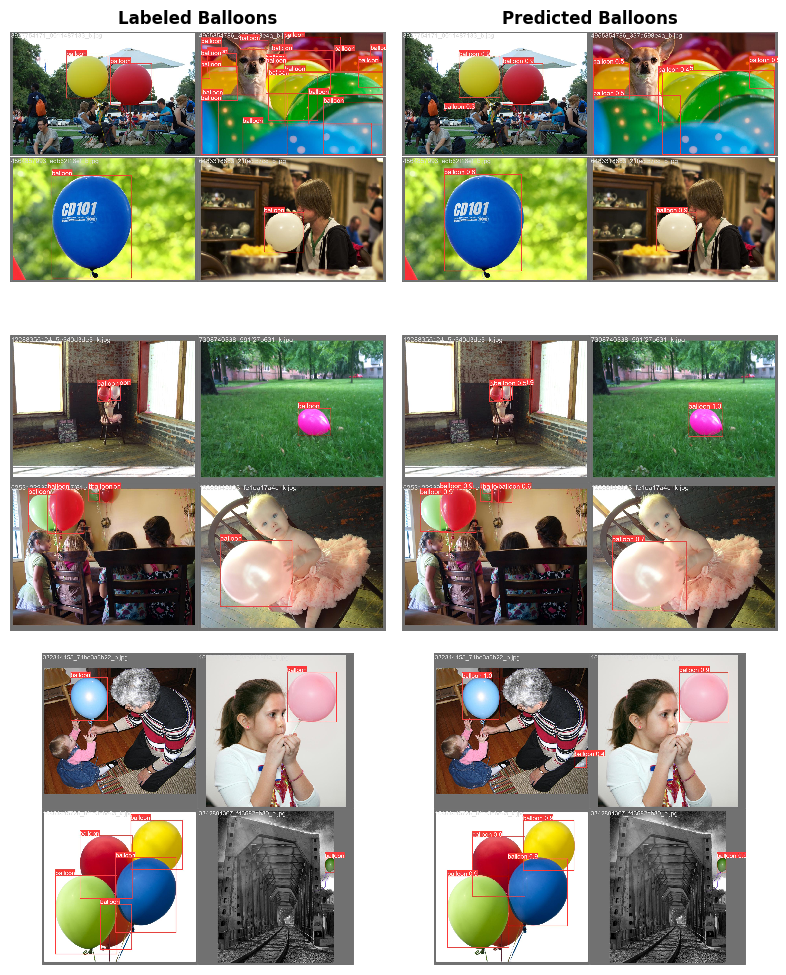

In [59]:
# Define the file locations of the images
img_files = [path2wm + 'val_batch0_labels.jpg', path2wm + 'val_batch0_pred.jpg',
             path2wm + 'val_batch1_labels.jpg', path2wm + 'val_batch1_pred.jpg',
             path2wm + 'val_batch2_labels.jpg', path2wm + 'val_batch2_pred.jpg',]

# Load the images into NumPy arrays
images = [mpimg.imread(f) for f in img_files]

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10), dpi=100)

# Set the left column to say "Labels" and the right column to say "Predicted"
axes[0, 0].set_title('Labeled Balloons', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Predicted Balloons', fontsize=12, fontweight='bold')


# Plot each image in a subplot
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i], interpolation='none')
    ax.set_axis_off()

# Display the plot
plt.tight_layout()
plt.show()

# Test Custom YOLOv5 Model on Original Image

detect: weights=['runs/train/wheatmodel6/weights/best.pt'], source=test/, data=data\coco128.yaml, imgsz=[1024, 1024], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=cpu, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'G:\My': No such file or directory
YOLOv5  2023-3-15 Python-3.7.9 torch-1.13.1+cu116 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients
image 1/5 G:\My Drive\RIT\Year 4\Spring 2023\Advanced Robotics\Project\Code\Balloon_Dataset\yolov5\test\test_image.jpg: 1024x768 1 balloon, 264.1ms
image 2/5 G:\My Drive\RIT\Year 4\Spring 2023\Advanced Robotics\Project\Code\Balloon_Dataset\yolov5\test\test_image2.jpg: 704x1024 (no detections), 250.0ms
image 3/5 G:\My Drive\RIT\Year 4\

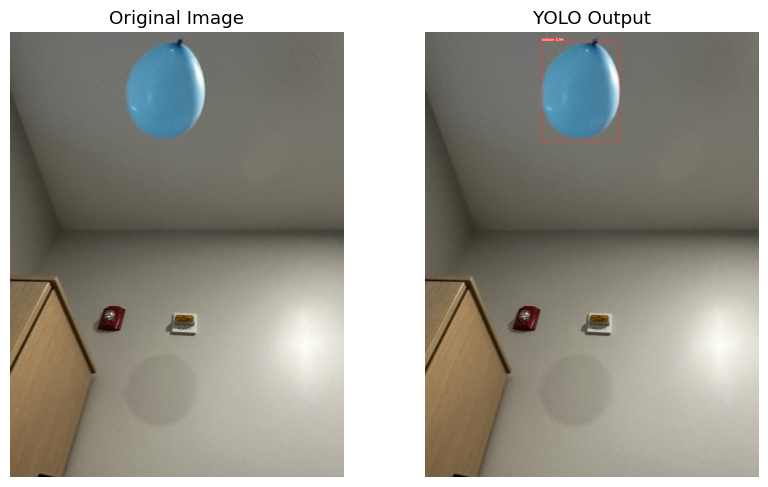

In [60]:
import torch
import torchvision
import cv2

# Make a prediction
!python detect.py --weights runs/train/wheatmodel6/weights/best.pt --img 1024 --conf 0.25 --source test/ --save-txt --save-conf --exist-ok --device cpu

# Load the predicted image and the original image
original = cv2.imread('test/test_image.jpg')
predicted = cv2.imread('runs/detect/exp/test_image.jpg')

# Convert the images from BGR to RGB
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)

# Display the two images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax1.imshow(original)
ax1.set_title('Original Image')
ax1.axis('off')
plt.tight_layout()


ax2.imshow(predicted)
ax2.set_title('YOLO Output')
ax2.axis('off')
plt.tight_layout()

plt.show()


# Print the location of the Bounding Box

In [30]:
import numpy as np

# Load the prediction results
with open('runs/detect/exp/labels/test_image.txt', 'r') as f:
    lines = f.readlines()

# Parse each line and extract the bounding box coordinates
bboxes = []
for line in lines:
    class_label, confidence, x, y, w, h = map(float, line.split())
    x1 = int((x - w/2) * original.shape[1])
    y1 = int((y - h/2) * original.shape[0])
    x2 = int((x + w/2) * original.shape[1])
    y2 = int((y + h/2) * original.shape[0])
    bboxes.append((x1, y1, x2, y2))

# The list `bboxes` now contains the coordinates of all predicted bounding boxes
print(bboxes)

[(59, -947, 742, 2830)]


# Test an image with no balloons

detect: weights=['runs/train/wheatmodel6/weights/best.pt'], source=test/, data=data\coco128.yaml, imgsz=[1024, 1024], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=cpu, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'G:\My': No such file or directory
YOLOv5  2023-3-15 Python-3.7.9 torch-1.13.1+cu116 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients
image 1/5 G:\My Drive\RIT\Year 4\Spring 2023\Advanced Robotics\Project\Code\Balloon_Dataset\yolov5\test\test_image.jpg: 1024x768 1 balloon, 298.3ms
image 2/5 G:\My Drive\RIT\Year 4\Spring 2023\Advanced Robotics\Project\Code\Balloon_Dataset\yolov5\test\test_image2.jpg: 704x1024 (no detections), 274.3ms
image 3/5 G:\My Drive\RIT\Year 4\

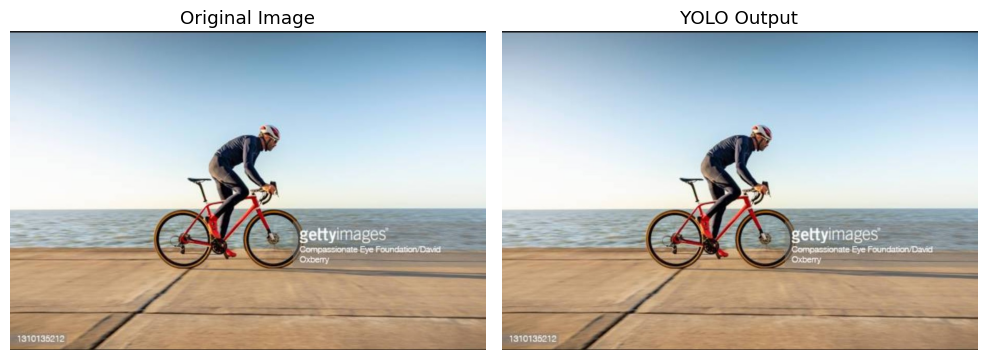

In [61]:
import torch
import torchvision
import cv2

# Make a prediction
!python detect.py --weights runs/train/wheatmodel6/weights/best.pt --img 1024 --conf 0.25 --source test/ --save-txt --save-conf --exist-ok --device cpu

# Load the predicted image and the original image
original = cv2.imread('test/test_image2.jpg')
predicted = cv2.imread('runs/detect/exp/test_image2.jpg')

# Convert the images from BGR to RGB
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)

# Display the two images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax1.imshow(original)
ax1.set_title('Original Image')
ax1.axis('off')
plt.tight_layout()


ax2.imshow(predicted)
ax2.set_title('YOLO Output')
ax2.axis('off')
plt.tight_layout()

plt.show()
